## Graph Space
$\textbf{Lead Author: Anna Calissano}$


Dear Learner,

in this notebook we are going to see gpca and regression in graph space in action.

In [1]:
import os
import sys
import warnings

import matplotlib.pyplot as plt
import networkx as nx

import geomstats.backend as gs

import geomstats.datasets.utils as data_utils

from geomstats.geometry.stratified.graph_space import (
    GraphSpace,
    GraphSpaceMetric,
)
from geomstats.learning.aac import AAC

gs.random.seed(2020)

warnings.filterwarnings("ignore")

INFO: Using numpy backend


# Mammals Grooming

## Motivation and Dataset
This case study focuses on how the social interaction between baboons changes after an alpha or beta male is knocked-out from the community. Social interaction is here defined as grooming interaction between members of the group. The dataset consists of a set of $26$ social interaction networks between baboons, where nodes are baboons and edges are the number of grooming interactions between baboons. The networks are naturally unlabelled because the baboons in each network are different, belonging to different groups. Data are available at Rossi et al. (2015), while more details about the case study are available at Franz et al. (2015). Notice that the original dataset was filtered, keeping only the networks with less than $20$ baboons. 

In [2]:
mammals = data_utils.load_mammals()

We visualize one mammals group:

In [3]:
mammals.max()

9.0

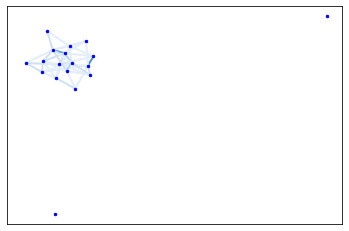

In [4]:
mammals_obs = nx.from_numpy_matrix(mammals[5])
pos = nx.kamada_kawai_layout(mammals_obs)
edges, weights = zip(*nx.get_edge_attributes(mammals_obs,'weight').items())

pos = nx.spring_layout(mammals_obs)
nx.draw_networkx_nodes(mammals_obs, pos, node_color='b', node_size=6)
nx.draw_networkx_edges(mammals_obs, pos, edgelist=edges, edge_color=weights, 
                       width=2.0, edge_cmap=plt.cm.Blues, edge_vmin=0., edge_vmax=10.)

### Frechet Mean
We compute the Frechet Mean of the set. We first initialize the graph space with the correct number of nodes (the adjacency matrices have been already padded with zeros), then we intialize the space metric and the parameters for the geodesic alignment. 

In [5]:
graph_space = GraphSpace(n_nodes=mammals.shape[1])
graph_space_metric = GraphSpaceMetric(space=graph_space)

graph_space_metric.set_aligner('FAQ')
aac_fm=AAC(estimate='frechet_mean', metric=graph_space_metric, max_iter = 300)

In [6]:
aac_fm.fit(mammals)

_AACFrechetMean(max_iter=300,
                metric=<geomstats.geometry.stratified.graph_space.GraphSpaceMetric object at 0x000001858A4267C0>,
                total_space_estimator_kwargs={})

Let's visualize the mean:

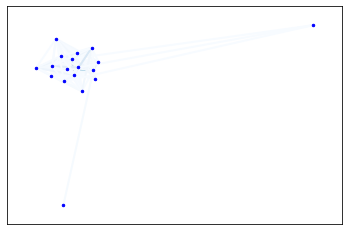

In [7]:
mammals_fm = nx.from_numpy_array(aac_fm.estimate_)
edges,weights = zip(*nx.get_edge_attributes(mammals_fm,'weight').items())

nx.draw_networkx_nodes(mammals_fm, pos, node_color='b', node_size=6)
nx.draw_networkx_edges(mammals_fm, pos, edgelist=edges, edge_color=weights,
                       width=2.0, edge_cmap=plt.cm.Blues, edge_vmin=0., edge_vmax=10.)

### Generalized Geodesic Principal Component Analysis (GGPCA)
We compute the principal components:

In [8]:
graph_space_metric.set_point_to_geodesic_aligner(aligner='default', s_min=mammals.min()-1, s_max=mammals.max() +1,
                                   n_points=5)

In [9]:
aac_ggpca = AAC(estimate='ggpca', metric=graph_space_metric, max_iter=5)
aac_ggpca.fit(mammals)

_AACGGPCA(max_iter=5,
          metric=<geomstats.geometry.stratified.graph_space.GraphSpaceMetric object at 0x000001858A4267C0>)

To visualize the GGPCA we plot the data along the geodesic:

In [10]:
aac_ggpca.components_.shape

(2, 18, 18)

Let's visualized the pricipal components:

In [11]:
aac_ggpca.explained_variance_ratio_

array([0.26419311, 0.14383405])

In [12]:
X_last = graph_space.permute(mammals, aac_ggpca.metric.point_to_geodesic_aligner.perm_)


The first geodesic principal components reflect the variability in terms of isolated nodes, the second principal component in terms of density. The example is able to show how the GGPCA in the Graph Space setting is capturing social interaction changes that the original paper Rossi et al. (2015) is not able to capture with standard Euclidean methods. This example is also naturally unlabelled, due to the different baboons in different groups (i.e. different nodes in different networks).


# GGRegression Fifa 2018 Player Passing Networks

## Motivation and Dataset
In this last case study, we studied the football players passing network (PPN) (i.e., the number of times two players
pass each other the ball throughout the match) as a function of the final match score. The analysis and visualization
of the players passing networks has becoming popular in the last years to understand the players network, the teams performance and strategy, and the final score. Using open source database in Stats Bomb, we collect all
the PPN of each team in each match for the whole Fifa 2018 World Championship. The dataset contains observations
about the 64 matches played (from 14/06/2018 to 15/07/2018) between 32 teams from all over the world.

In [13]:
ppn, scores = data_utils.load_football()

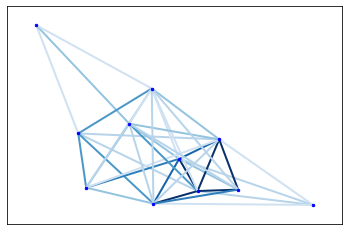

In [14]:
ppn_obs = nx.from_numpy_matrix(ppn[5])
pos = nx.kamada_kawai_layout(ppn_obs)
edges, weights = zip(*nx.get_edge_attributes(ppn_obs,'weight').items())

pos = nx.spring_layout(ppn_obs)
nx.draw_networkx_nodes(ppn_obs, pos, node_color='b', node_size=6)
nx.draw_networkx_edges(ppn_obs, pos, edgelist=edges, edge_color=weights, width=2.0,
                       edge_cmap=plt.cm.Blues, edge_vmin=0., edge_vmax=10.)

In [15]:
graph_space = GraphSpace(n_nodes=ppn.shape[1])
graph_space_metric = GraphSpaceMetric(space=graph_space)
graph_space_metric.set_aligner('FAQ')

aac_reg = AAC(estimate='regression', metric=graph_space_metric)
aac_reg.fit(X=gs.expand_dims(scores, axis=1), y=ppn)

_AACRegressor(metric=<geomstats.geometry.stratified.graph_space.GraphSpaceMetric object at 0x000001858A567F40>,
              total_space_estimator_kwargs={})

### References:
 
Franz, M., Altmann, J., & Alberts, S. C. (2015). Knockouts of high-ranking males have limited impact on baboon social networks. Current Zoology, 61(1), 107-113.

S. S. Ltd, Statsbomb open data, https://github.com/statsbomb/open-data (2018).

Rossi, R., & Ahmed, N. (2015, March). The network data repository with interactive graph analytics and visualization. In Twenty-ninth AAAI conference on artificial intelligence.
